In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoImageProcessor 
from PIL import Image
import requests
import matplotlib.pyplot as plt
import pandas as pd


/home/aws_install/miniforge3/envs/exp_multi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#pip install einops

In [ ]:
processor = AutoImageProcessor.from_pretrained("nomic-ai/nomic-embed-vision-v1.5")
vision_model = AutoModel.from_pretrained("nomic-ai/nomic-embed-vision-v1.5",trust_remote_code = True)

In [78]:
image = Image.open("test.png")

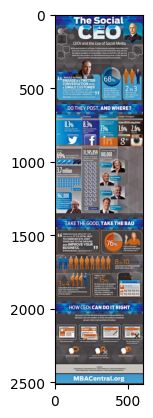

In [9]:
plt.imshow(image)
plt.show()


In [10]:
inputs = processor(image, return_tensors="pt")
img_emb = vision_model(**inputs).last_hidden_state
img_embeddings = F.normalize(img_emb[:,0],p=2,dim=1)

In [11]:
def mean_pooling(model_output,attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings* input_mask_expanded,1) /torch.clamp(input_mask_expanded.sum(1),min=1e-9)

In [18]:
tokenizer = AutoTokenizer.from_pretrained('nomic-ai/nomic-embed-text-v1.5')
text_model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1.5',trust_remote_code=True)
text_model.eval()

<All keys matched successfully>


NomicBertModel(
  (embeddings): NomicBertEmbeddings(
    (word_embeddings): Embedding(30528, 768)
    (token_type_embeddings): Embedding(2, 768)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (encoder): NomicBertEncoder(
    (layers): ModuleList(
      (0-11): 12 x NomicBertBlock(
        (attn): NomicBertAttention(
          (rotary_emb): NomicBertRotaryEmbedding()
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (out_proj): Linear(in_features=768, out_features=768, bias=False)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (mlp): NomciBertGatedMLP(
          (fc11): Linear(in_features=768, out_features=3072, bias=False)
          (fc12): Linear(in_features=768, out_features=3072, bias=False)
          (fc2): Linear(in_features=3072, out_features=768, bias=False)
          (norm): Identity()
        )
        (dropout1): Dropout(p=0.0, inplace=False)
        (norm1

In [20]:
sentences =  ["search_query: Who is the CEO ?","search_query: What is the color of the car ?"]

In [21]:
encoded_input = tokenizer(sentences,padding=True,truncation=True,return_tensors="pt")
with torch.no_grad():
    model_output = text_model(**encoded_input)

text_embeddings = mean_pooling(model_output,encoded_input['attention_mask'])
text_embeddings = F.layer_norm(text_embeddings, normalized_shape=(text_embeddings.shape[1],))
img_embeddings = F.normalize(text_embeddings,p=2,dim=1)

print(torch.matmul(img_embeddings,text_embeddings.T))

tensor([[27.7126, 12.5062],
        [12.5062, 27.7126]])


### Extract Imgs from Pdfs

In [2]:
pdf_sample_path = "../data/ECSS-E-HB-10-02A.pdf"

#### DocLayout-YOLO

In [69]:
import cv2
from doclayout_yolo import YOLOv10

In [ ]:
from huggingface_hub import hf_hub_download
#pip install huggingface_hub

In [72]:
filepath = hf_hub_download(repo_id="juliozhao/DocLayout-YOLO-DocStructBench", filename="doclayout_yolo_docstructbench_imgsz1024.pt")
model = YOLOv10(filepath)

In [81]:
# Perform prediction
det_res = model.predict(
    "test_ecss.png",   # Image to predict
    imgsz=1024,        # Prediction image size
    conf=0.2,          # Confidence threshold
    device="cuda:0"    # Device to use (e.g., 'cuda:0' or 'cpu')
)


image 1/1 /home/aws_install/exp_multi_rag/Notebooks/test_ecss.png: 1024x768 1 title, 7 plain texts, 2 abandons, 1 figure, 1 figure_caption, 27.4ms
Speed: 4.7ms preprocess, 27.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 768)


In [80]:
# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
cv2.imwrite("result.jpg", annotated_frame)

True

### Layout Pipeline

In [ ]:
import cv2
from doclayout_yolo import YOLOv10
from huggingface_hub import hf_hub_download
from pdf2image import convert_from_path # You'll need to install this
import os
from PIL import Image # For working with PIL images


def process_pdf_for_layout_extraction(pages):
    
    print(f"Converted {len(pages)} pages.")
    all_extracted_layouts = []
    for page_num, page_image in enumerate(pages):
        print(f"\nProcessing Page {page_num + 1}...")


        # 2. Perform layout detection
        det_res = model.predict(
            page_image,         # Pass the PIL image directly
            imgsz=1024,         # Prediction image size
            conf=0.2,           # Confidence threshold
            device="cuda:0"     # Device to use (e.g., 'cuda:0' or 'cpu')
        )

        # 3. Iterate through detections, crop, and save
        if det_res and len(det_res[0].boxes) > 0:
            print(f"Found {len(det_res[0].boxes)} detections on Page {page_num + 1}.")
            for i, box in enumerate(det_res[0].boxes):
                x1, y1, x2, y2 = map(int, box.xyxy[0]) # Get bounding box coordinates
                confidence = box.conf[0]
                class_id = int(box.cls[0])
                class_name = model.names[class_id]

                # Ensure coordinates are within image bounds
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(page_image.width, x2)
                y2 = min(page_image.height, y2)

                # Crop the image using PIL's crop method
                cropped_region = page_image.crop((x1, y1, x2, y2))
                
                all_extracted_layouts.append({
                    "image": cropped_region,
                    "class_name": class_name,
                    "confidence": confidence,
                    "page_num": page_num + 1,
                    "bbox": (x1, y1, x2, y2)
                })

        else:
            print(f"No detections found on Page {page_num + 1}.")
    return all_extracted_layouts


In [84]:
# 1. Load your YOLOv10 model (as you already have)
filepath = hf_hub_download(repo_id="juliozhao/DocLayout-YOLO-DocStructBench", filename="doclayout_yolo_docstructbench_imgsz1024.pt")
model = YOLOv10(filepath)

pages = convert_from_path(pdf_sample_path)

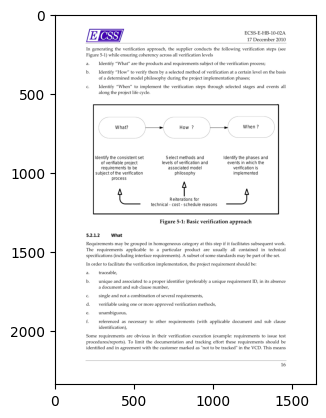

In [103]:
plt.imshow(pages[15])
plt.show()

In [119]:
layouts = process_pdf_for_layout_extraction(pages)

Converted 96 pages.

Processing Page 1...

0: 1024x736 1 title, 3 plain texts, 3 abandons, 1 figure, 26.8ms
Speed: 4.7ms preprocess, 26.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)
Found 8 detections on Page 1.

Processing Page 2...

0: 1024x736 3 titles, 7 plain texts, 3 abandons, 25.9ms
Speed: 4.6ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 736)
Found 13 detections on Page 2.

Processing Page 3...

0: 1024x736 3 titles, 7 plain texts, 3 abandons, 25.9ms
Speed: 4.4ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 736)
Found 13 detections on Page 3.

Processing Page 4...

0: 1024x736 4 titles, 3 plain texts, 3 abandons, 25.9ms
Speed: 4.5ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 736)
Found 10 detections on Page 4.

Processing Page 5...

0: 1024x736 2 titles, 2 plain texts, 2 abandons, 25.9ms
Speed: 4.5ms preprocess, 25.9ms inference, 0.8ms postprocess 

##### Removing ducplicate

In [114]:
#pip install imagehash
import imagehash

In [122]:
def remove_duplicate_layouts(layouts_list, hash_size=8, threshold=0):
    
    unique_hashes = set()
    unique_layouts = []
    
    print("\nStarting duplicate removal...")
    for layout in layouts_list:
        img = layout["image"]
        # Convert image to grayscale for hashing (perceptual hash often works best on grayscale)
        img_gray = img.convert("L") 
        current_hash = imagehash.phash(img_gray, hash_size=hash_size)

        is_duplicate = False
        for uhash in unique_hashes:
            if current_hash - uhash <= threshold: # Compare hashes
                is_duplicate = True
                break
        
        if not is_duplicate:
            unique_hashes.add(current_hash)
            unique_layouts.append(layout)
            print(f"Added unique layout (Class: {layout['class_name']}, Page: {layout['page_num']})")
        else:
            print(f"Skipped duplicate layout (Class: {layout['class_name']}, Page: {layout['page_num']})")

    print(f"\nRemoved {len(layouts_list) - len(unique_layouts)} duplicates.")
    return unique_layouts

In [123]:
layouts_unique = remove_duplicate_layouts(layouts)


Starting duplicate removal...
Added unique layout (Class: title, Page: 1)
Added unique layout (Class: plain text, Page: 1)
Added unique layout (Class: plain text, Page: 1)
Added unique layout (Class: abandon, Page: 1)
Skipped duplicate layout (Class: abandon, Page: 1)
Added unique layout (Class: abandon, Page: 1)
Skipped duplicate layout (Class: figure, Page: 1)
Skipped duplicate layout (Class: plain text, Page: 1)
Added unique layout (Class: plain text, Page: 2)
Added unique layout (Class: plain text, Page: 2)
Added unique layout (Class: plain text, Page: 2)
Added unique layout (Class: plain text, Page: 2)
Added unique layout (Class: abandon, Page: 2)
Added unique layout (Class: abandon, Page: 2)
Added unique layout (Class: title, Page: 2)
Added unique layout (Class: title, Page: 2)
Added unique layout (Class: plain text, Page: 2)
Added unique layout (Class: abandon, Page: 2)
Added unique layout (Class: title, Page: 2)
Added unique layout (Class: plain text, Page: 2)
Added unique lay

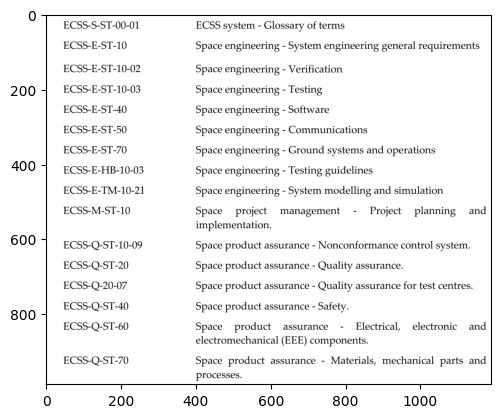

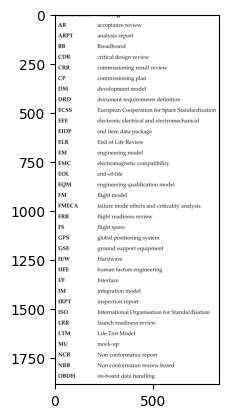

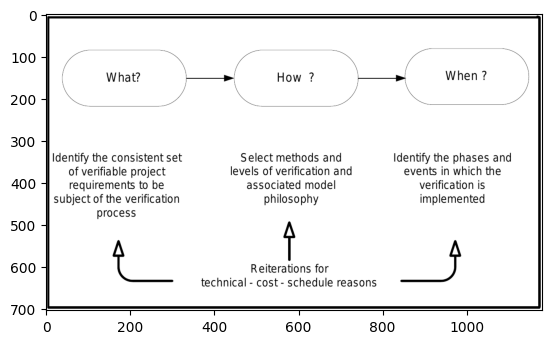

In [137]:
for l in layouts_unique[:200]:
    if l["class_name"] in ["figure","table"] :
      plt.imshow(l["image"])
      plt.show()

### PdfPlumber

In [126]:
import pdfplumber
#pip install pdfplumber tabulate

In [127]:
def clean_table(table):
        df = pd.DataFrame(table)
        df_cleaned = df.dropna(axis=1, how='all')
        df_cleaned = df_cleaned.dropna(how='all')
        return df_cleaned

In [ ]:
text_content = []
tables_content = []
images_content = []
with pdfplumber.open(pdf_sample_path) as pdf:
    for page in pdf.pages:
        text_content.append(page.extract_text())

In [132]:
text_content

['ECSS-E-HB-10-02A\n17 December 2010\nSpace engineering\nVerification guidelines\nECSS Secretariat\nESA-ESTEC\nRequirements & Standards Division\nNoordwijk, The Netherlands',
 'ECSS‐E‐HB‐10‐02A\n17 December 2010\nForeword\nThis Handbook is one document of the series of ECSS Documents intended to be used as supporting\nmaterial for ECSS Standards in space projects and applications. ECSS is a cooperative effort of the\nEuropean Space Agency, national space agencies and European industry associations for the purpose\nof developing and maintaining common standards.\nThe material in this Handbook is defined in terms of description and recommendation how to\norganize and perform the work of verification of a space system product, as specified in the ECSS‐ST‐\n10‐02.\nThis handbook has been prepared by the ECSS‐E‐HB‐10‐02 Working Group, reviewed by the ECSS\nExecutive Secretariat and approved by the ECSS Technical Authority.\nDisclaimer\nECSS does not provide any warranty whatsoever, whether 